In [ ]:

# We can use a combination of Python scripts to find the shortest distances between different addresses. In the example 
# below, we have five addresses, saved in a list, and displayed in no particular order. The objective is to get the 
# addresses arranged in the most efficient order, so we travel the shortest  distance, and finish the trip as quickly 
# as possible.


In [45]:

import googlemaps
import folium
from IPython.display import display

def optimize_routes(api_key, addresses):
    gmaps = googlemaps.Client(key=api_key)

    # Initialize an empty matrix to store distances
    distances = []

    # Fetch distances from Google Maps Distance Matrix API
    for origin in addresses:
        row = []
        for destination in addresses:
            matrix = gmaps.distance_matrix([origin], [destination], mode="driving")
            row.append(matrix['rows'][0]['elements'][0]['duration']['value'])
        distances.append(row)

    # Find the closest locations and reorder the addresses
    closest_order = find_closest_locations(distances)
    optimized_route = [addresses[i] for i in closest_order]

    # Calculate the total distance traveled
    total_distance = calculate_total_distance(optimized_route, gmaps)

    return optimized_route, total_distance

def find_closest_locations(distances):
    num_locations = len(distances)
    unvisited = set(range(num_locations))
    current_location = 0
    order = [current_location]

    while unvisited:
        # Calculate distances only to unvisited locations
        nearest_neighbor = min(unvisited, key=lambda x: distances[current_location][x])
        order.append(nearest_neighbor)
        unvisited.remove(nearest_neighbor)
        current_location = nearest_neighbor

    return order

def calculate_total_distance(route, gmaps):
    total_distance = 0
    for i in range(len(route) - 1):
        origin = route[i]
        destination = route[i + 1]
        matrix = gmaps.distance_matrix([origin], [destination], mode="driving")
        total_distance += matrix['rows'][0]['elements'][0]['distance']['value']

    return total_distance

def plot_route_on_map(api_key, addresses):
    gmaps = googlemaps.Client(key=api_key)

    # Optimize routes and get the optimized route
    optimized_route, _ = optimize_routes(api_key, addresses)

    # Get the coordinates of each address
    coordinates = [gmaps.geocode(address)[0]['geometry']['location'] for address in optimized_route]

    # Create a folium map centered on the first address
    map_center = coordinates[0]
    my_map = folium.Map(location=[map_center['lat'], map_center['lng']], zoom_start=14)

    # Plot markers for each address
    for coord, address in zip(coordinates, optimized_route):
        folium.Marker(location=[coord['lat'], coord['lng']], popup=address).add_to(my_map)

    # Draw the route on the map
    folium.PolyLine(locations=[[coord['lat'], coord['lng']] for coord in coordinates],
                    color='blue',
                    weight=5,
                    opacity=0.7).add_to(my_map)

    # Display the map in the Jupyter Notebook
    display(my_map)
    

In [46]:

# Replace 'YOUR_API_KEY' with your actual Google Maps API key
api_key = 'your_api_key'
addresses = ["509 48th Avenue, Long Island City, NY 11101", 
             "102 Montague St, Brooklyn, NY 11201",
             "100 Wall St, New York, NY 10005",
             "4705 Center Blvd, Long Island City, NY 11109",
             "607 Humboldt St, Brooklyn, NY 11222"]

plot_route_on_map(api_key, addresses)


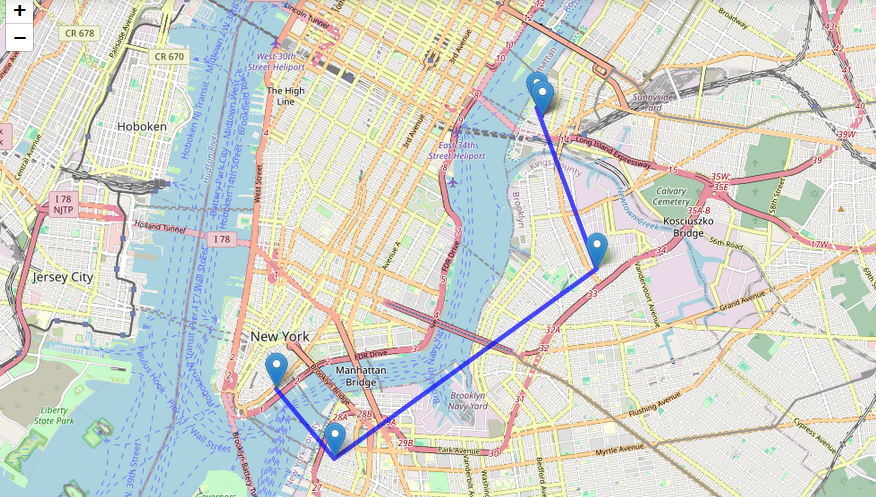

In [47]:

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "C:\\Users\\"
Image(filename = PATH + "1.JPG")


In [ ]:

# In the example above, we found the shortest distance between various end points. However, the shortest distance was 
# actually a straight line, and although that works in the mathematics world, it wouldn't work in the real world, because
# we are most likely driving on streets and not flying between destinations. The code below uses the polyline module to 
# decode the overview_polyline from the Google Maps API response, and draw the road-based route on the map. This code
# uses the Directions API from Google Maps to extract coordinates from the Google Maps API response, and thereby achieve 
# the goal of getting directions, and distances, between various destinations.


In [35]:

import googlemaps
import folium
from IPython.display import display
import polyline


def optimize_routes(api_key, addresses):
    gmaps = googlemaps.Client(key=api_key)

    # Find the closest locations and reorder the addresses
    closest_order = find_closest_locations(gmaps, addresses)
    optimized_route = [addresses[i] for i in closest_order]

    # Calculate the total distance traveled
    total_distance = calculate_total_distance(gmaps, optimized_route)

    return optimized_route, total_distance

def find_closest_locations(gmaps, addresses):
    num_locations = len(addresses)
    unvisited = set(range(num_locations))
    current_location = 0
    order = [current_location]

    while unvisited:
        # Calculate distances only to unvisited locations
        nearest_neighbor = min(unvisited, key=lambda x: get_distance(gmaps, addresses[current_location], addresses[x]))
        order.append(nearest_neighbor)
        unvisited.remove(nearest_neighbor)
        current_location = nearest_neighbor

    return order

def get_distance(gmaps, origin, destination):
    directions_result = gmaps.directions(origin, destination, mode="driving")
    return directions_result[0]['legs'][0]['distance']['value']

def calculate_total_distance(gmaps, route):
    total_distance = 0
    for i in range(len(route) - 1):
        origin = route[i]
        destination = route[i + 1]
        total_distance += get_distance(gmaps, origin, destination)
        print('total of: ' + str(total_distance) + ' meters traveled')
    return total_distance

def plot_route_on_map(api_key, addresses):
    gmaps = googlemaps.Client(key=api_key)

    # Optimize routes and get the optimized route
    optimized_route, _ = optimize_routes(api_key, addresses)

    # Create a folium map centered on the first address
    map_center = gmaps.geocode(optimized_route[0])[0]['geometry']['location']
    my_map = folium.Map(location=[map_center['lat'], map_center['lng']], zoom_start=14)

    # Plot markers for each address
    for address in optimized_route:
        location = gmaps.geocode(address)[0]['geometry']['location']
        folium.Marker(location=[location['lat'], location['lng']], popup=address).add_to(my_map)

    # Draw the road-based route on the map
    coordinates = []
    for i in range(len(optimized_route) - 1):
        origin = gmaps.geocode(optimized_route[i])[0]['geometry']['location']
        destination = gmaps.geocode(optimized_route[i + 1])[0]['geometry']['location']
        directions_result = gmaps.directions(origin, destination, mode="driving", alternatives=False)
        steps = directions_result[0]['legs'][0]['steps']
        for step in steps:
            coordinates.extend(polyline.decode(step['polyline']['points']))

    folium.PolyLine(locations=coordinates,
                    color='blue',
                    weight=5,
                    opacity=0.7).add_to(my_map)

    # Display the map in the Jupyter Notebook
    display(my_map)


In [36]:

# Replace 'YOUR_API_KEY' with your actual Google Maps API key
api_key = 'your_api_key'
addresses = ["509 48th Avenue, Long Island City, NY 11101", 
             "102 Montague St, Brooklyn, NY 11201",
             "100 Wall St, New York, NY 10005",
             "4705 Center Blvd, Long Island City, NY 11109",
             "607 Humboldt St, Brooklyn, NY 11222"]

plot_route_on_map(api_key, addresses)


total of: 0 meters traveled
total of: 339 meters traveled
total of: 3960 meters traveled
total of: 11145 meters traveled
total of: 15412 meters traveled


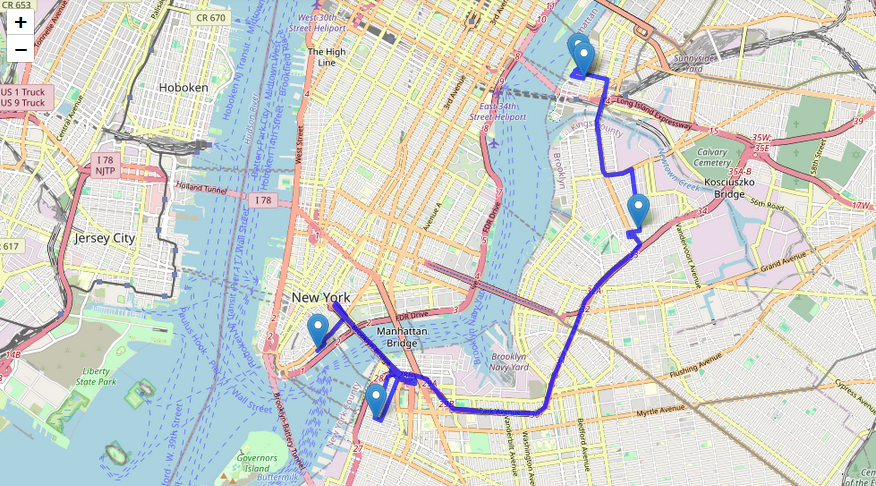

In [48]:

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "C:\\Users\\"
Image(filename = PATH + "2.JPG")


In [ ]:

# End...
